In [23]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf

# Part 1: Extract and Load (EL) Implementation

API Dataset (Coingecko)

In [24]:
COINGECKO_URL = "https://api.coingecko.com/api/v3/coins/markets"

COINGECKO_PARAMS = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 10,
    "page": 1,
    "sparkline": False
}

YF_TICKERS = ["PYPL", "MA", "V"]
YF_START = "2021-01-01"
YF_END = "2026-01-01"

In [33]:
def create_directories():
    os.makedirs("data/raw", exist_ok=True)
    os.makedirs("data/processed", exist_ok=True)
    os.makedirs("data/cleaned", exist_ok=True)
    print("Folders created successfully.")
create_directories()

Folders created successfully.


In [34]:
def extract_crypto_data():
    response = requests.get(COINGECKO_URL, params=COINGECKO_PARAMS)
    data = response.json()
    crypto_df = pd.DataFrame(data)
    return crypto_df

In [51]:
def save_crypto_data(crypto_df):
    crypto_df.to_json("data/raw/crypto_data.json", orient="records")
    crypto_df.to_csv("data/processed/crypto_data.csv", index=False)

Public Dataset (Data from Kaggle)

In [36]:
def extract_public_data():
    public_df = pd.read_csv("data/raw/fintech_transaction.csv")
    return public_df

In [53]:
def save_public_data(public_df):
    public_df.to_csv("data/processed/public_data.csv", index=False)
    public_df.to_json("data/raw/public_data.json", orient="records")

Data from Y Finance (Yahoo/Timeseries)

In [54]:
def extract_finance_data():
    yf_data = yf.download(YF_TICKERS, start=YF_START, end=YF_END)["Close"]
    yf_data.reset_index(inplace=True)
    return yf_data

In [55]:
def save_finance_data(yf_df):
    yf_df.to_csv("data/processed/finance_timeseries.csv", index=False)
    yf_df.to_json("data/raw/finance_timeseries.json", orient="records")

# Part 2: Transform, Clean, and Analyze

In [56]:
def clean_crypto_data(crypto_df):
    crypto_df['max_supply'] = crypto_df['max_supply'].fillna(0)
    crypto_df['roi'] = crypto_df['roi'].fillna(0)
    crypto_df.to_csv("data/cleaned/crypto_cleaned.csv", index=False)
    crypto_df.to_json("data/cleaned/crypto_cleaned.json", orient="records")
    return crypto_df

In [57]:
def clean_upi_data(upi_df):
    upi_df['Date'] = pd.to_datetime(upi_df['Year'].astype(str) + '-' + upi_df['Month'].astype(str) + '-01')
    upi_df.to_csv("data/cleaned/upi_cleaned.csv", index=False)
    upi_df.to_json("data/cleaned/upi_cleaned.json", orient="records")
    return upi_df

In [58]:
def clean_finance_data(yf_df):
    yf_df.to_csv("data/cleaned/finance_cleaned.csv", index=False)
    yf_df.to_json("data/cleaned/finance_cleaned.json", orient="records")
    return yf_df

In [66]:
def check_quality(df, name):
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    print("Missing values:\n", df.isnull().sum())

    # Only check duplicates on hashable columns
    hashable_cols = [col for col in df.columns if df[col].apply(lambda x: not isinstance(x, dict)).all()]
    if hashable_cols:
        print("Duplicate rows:", df[hashable_cols].duplicated().sum())
    else:
        print("Duplicate rows: Cannot check (dict columns present)")

    print("\n")

In [73]:
def summary_statistics(df, name):
    print(f"--- Summary Statistics: {name} ---")
    display(df.describe()) 
    print("\n")

# Exploratory Analysis and Visualization

In [67]:
def plot_stock_trends(yf_df):
    yf_df['Date'] = pd.to_datetime(yf_df['Date'])
    yf_df = yf_df.sort_values('Date')
    
    plt.figure(figsize=(14,6))
    plt.plot(yf_df['Date'], yf_df['PYPL'], label='PYPL', marker='o', markersize=3)
    plt.plot(yf_df['Date'], yf_df['MA'], label='MA', marker='o', markersize=3)
    plt.plot(yf_df['Date'], yf_df['V'], label='V', marker='o', markersize=3)

    plt.title("Stock Price Trends of FinTech Companies (2021-2026)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (USD)")
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [61]:
def plot_upi_trend(upi_df):
    upi_df['Month-Year'] = pd.to_datetime(
        upi_df['Month'].astype(str) + '-' + upi_df['Year'].astype(str),
        format='%m-%Y'
    )
    monthly_trend = upi_df.groupby('Month-Year')['Volume (Mn)'].sum()
    plt.figure(figsize=(12,5))
    plt.plot(monthly_trend.index, monthly_trend.values, marker='o')
    plt.title("Monthly UPI Transaction Volume Trend")
    plt.xlabel("Month-Year")
    plt.ylabel("Volume (Mn)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [62]:
def plot_correlation(yf_df):
    corr = yf_df[['PYPL', 'MA', 'V']].corr()
    sns.heatmap(corr, annot=True, cmap='Blues')
    plt.title("Correlation between FinTech Stock Prices")
    plt.show()

In [63]:
def plot_top_banks(upi_df):
    top_banks = upi_df.groupby('UPI Banks')['Volume (Mn)'].sum().sort_values(ascending=True).tail(5)
    top_banks.plot(kind='barh', figsize=(10,6), color='skyblue')
    plt.title("Top 5 Banks by UPI Transaction Volume")
    plt.xlabel("Volume (Mn)")
    plt.ylabel("Bank")
    plt.show()

In [64]:
def plot_top_crypto(crypto_df):
    top_crypto = crypto_df.sort_values(by='market_cap', ascending=False).head(10)
    
    plt.figure(figsize=(12,6))
    sns.barplot(data=top_crypto, x='Cryptocurrency', y='Market Cap (USD)', palette='viridis')
    plt.title("Top 10 Cryptocurrencies by Market Cap")
    plt.xticks(rotation=45)
    plt.show()
    
    plt.figure(figsize=(8,8))
    plt.pie(top_crypto['market_cap'], labels=top_crypto['name'], autopct='%1.1f%%', startangle=140)
    plt.title("Market Cap Distribution of Top 10 Cryptocurrencies")
    plt.show()

# Main Pipeline

Folders created successfully.


[*********************100%***********************]  3 of 3 completed


--- Crypto Data ---
Shape: (10, 26)
Missing values:
 id                                  0
symbol                              0
name                                0
image                               0
current_price                       0
market_cap                          0
market_cap_rank                     0
fully_diluted_valuation             0
total_volume                        0
high_24h                            0
low_24h                             0
price_change_24h                    0
price_change_percentage_24h         0
market_cap_change_24h               0
market_cap_change_percentage_24h    0
circulating_supply                  0
total_supply                        0
max_supply                          7
ath                                 0
ath_change_percentage               0
ath_date                            0
atl                                 0
atl_change_percentage               0
atl_date                            0
roi                                

,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,low_24h,price_change_24h,price_change_percentage_24h,market_cap_change_24h,market_cap_change_percentage_24h,circulating_supply,total_supply,max_supply,ath,ath_change_percentage,atl,atl_change_percentage
count,10.000000,1.000000e+01,10.00000,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,1.000000e+01
mean,7308.073354,2.204608e+11,5.50000,2.276385e+11,1.644454e+10,7373.466441,7204.714861,0.087119,1.905287,6.128196e+08,1.957219,5.977272e+10,6.423965e+10,1.002210e+10,13269.802287,-46.709944,7.039370,2.383399e+05
std,22141.212255,4.228615e+11,3.02765,4.210197e+11,2.613451e+10,22330.036250,21822.974278,17.541406,4.759957,2.784140e+09,4.782467,7.058581e+10,7.276551e+10,3.161507e+10,39667.669743,22.004800,21.354757,4.934323e+05
min,0.113121,1.546202e+10,1.00000,1.546202e+10,5.654200e+04,0.116792,0.099364,-36.729762,-1.751140,-4.433026e+09,-1.751150,1.998955e+07,1.998961e+07,0.000000e+00,0.431288,-84.537470,0.000087,1.393211e+01
25%,0.999694,3.263093e+10,3.25000,3.380130e+10,1.394914e+09,0.999929,0.999627,-0.010905,-0.780960,-2.296204e+08,-0.772465,2.442589e+08,2.573673e+08,0.000000e+00,1.207500,-57.951595,0.011969,4.285167e+03
50%,1.300000,7.972067e+10,5.50000,7.972927e+10,4.134054e+09,1.347000,1.239500,0.000005,0.000475,1.151218e+07,0.013945,3.803882e+10,4.437887e+10,0.000000e+00,2.510000,-49.137960,0.294168,3.812819e+04
75%,494.632500,1.617593e+11,7.75000,1.812915e+11,1.953486e+10,503.280000,491.820000,0.086552,2.099608,1.299740e+09,2.236492,8.943650e+10,9.867044e+10,1.575000e+07,1100.820000,-27.863933,0.554591,1.234425e+05
max,70296.000000,1.404940e+12,10.00000,1.404945e+12,7.935397e+10,70898.000000,69287.000000,37.530000,13.005280,6.777079e+09,13.124580,1.837553e+11,1.892839e+11,1.000000e+11,126080.000000,-14.733850,67.810000,1.581544e+06




--- Summary Statistics: UPI Transactions ---


,Volume (Mn) By Costumers,Value (Cr) by Costumers,Volume (Mn),Value (Cr),Month,Year
count,654.000000,654.000000,654.000000,654.000000,654.000000,654.0
mean,57.960948,10943.292813,60.460321,11134.196682,6.571865,2021.0
std,256.842682,49450.615924,258.686922,49588.538504,3.488797,0.0
min,0.010000,0.410000,0.010000,0.410000,1.000000,2021.0
25%,0.050000,21.132500,0.050000,21.132500,3.250000,2021.0
50%,0.250000,60.640000,0.250000,60.745000,7.000000,2021.0
75%,2.357500,401.312500,2.357500,407.062500,10.000000,2021.0
max,2077.600000,394565.580000,2077.600000,394565.580000,12.000000,2021.0




--- Summary Statistics: Finance Time-Series ---


Ticker,MA,PYPL,V
count,1255.000000,1255.000000,1255.000000
mean,417.354193,111.386177,252.717737
std,86.960657,74.879904,52.786643
min,278.024170,50.273781,172.935867
25%,348.435501,65.224216,211.186783
50%,381.064667,75.016586,230.906860
75%,490.067612,102.503036,280.998322
max,597.273193,307.818390,371.152252


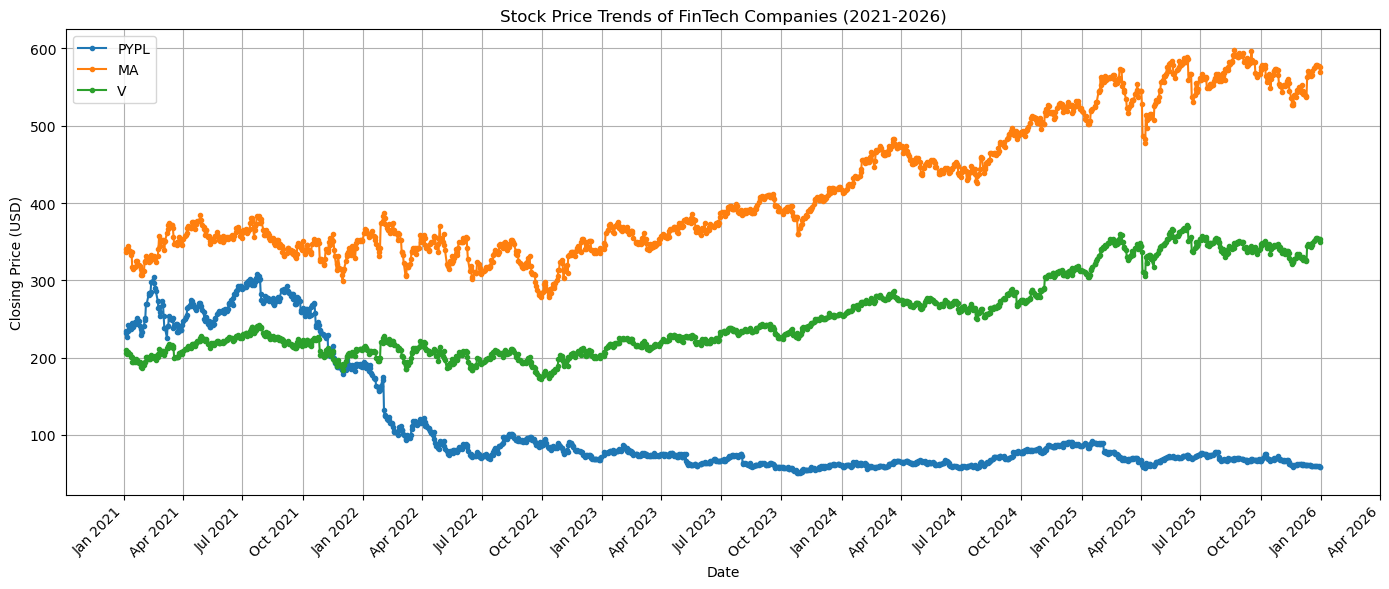

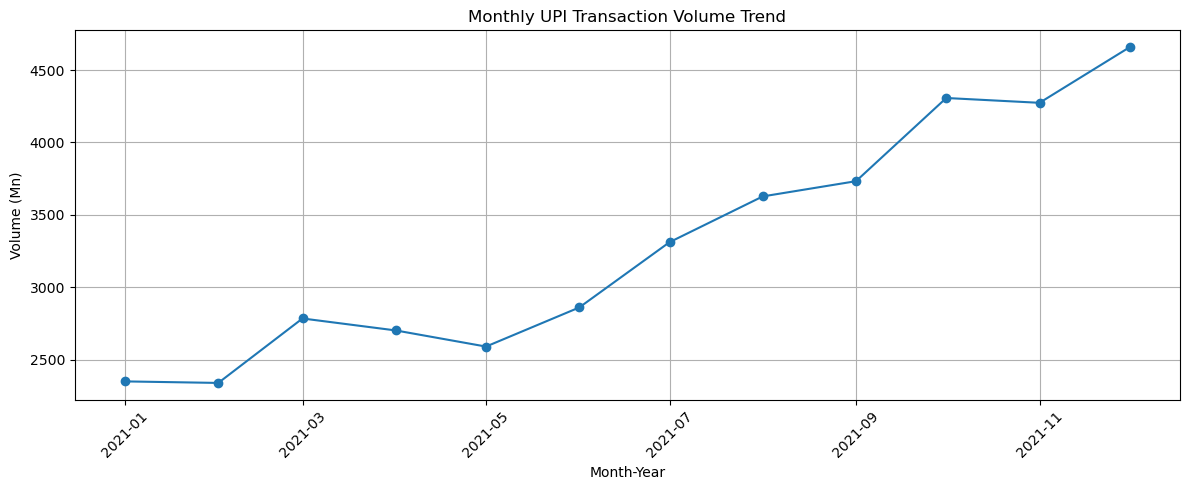

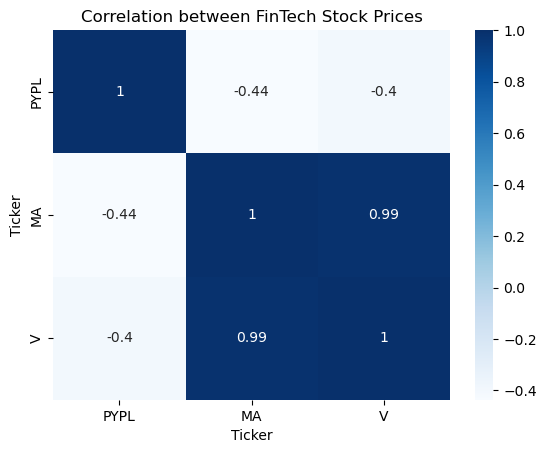

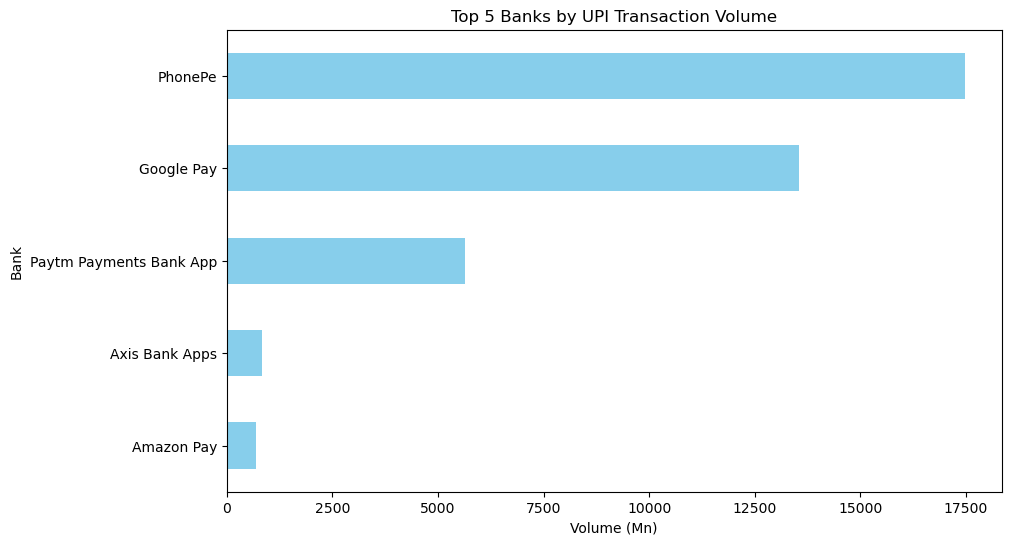

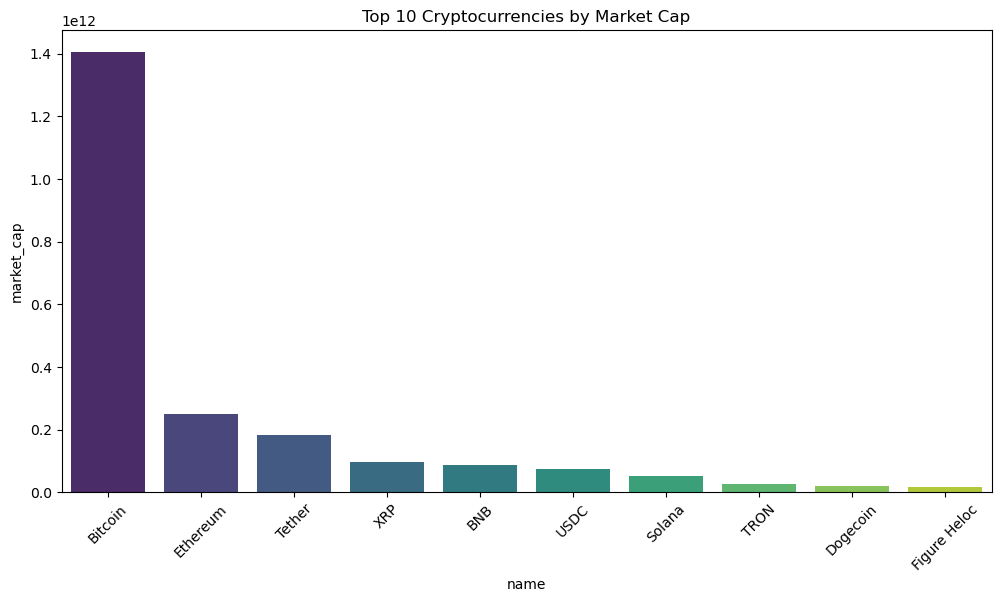

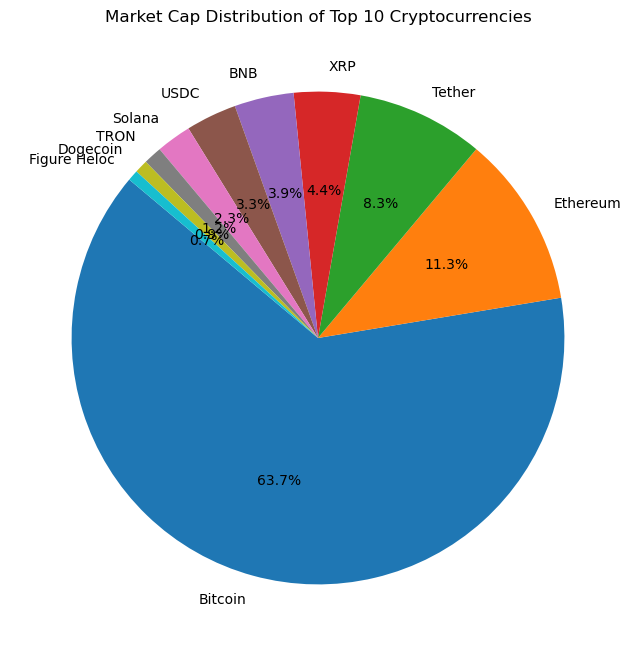

In [74]:
def main():
    # Create folders
    create_directories()
    
    # Extract
    crypto_df = extract_crypto_data()
    public_df = extract_public_data()
    yf_df = extract_finance_data()
    
    # Save raw + processed
    save_crypto_data(crypto_df)
    save_public_data(public_df)
    save_finance_data(yf_df)
    
    # Data quality check
    check_quality(crypto_df, "Crypto Data")
    check_quality(public_df, "UPI Transactions")
    check_quality(yf_df, "Finance Time-Series")
    
    # Clean
    crypto_df = clean_crypto_data(crypto_df)
    public_df = clean_upi_data(public_df)
    yf_df = clean_finance_data(yf_df)
    
    #Summary Statistics (numeric columns only)
    summary_statistics(crypto_df, "Crypto Data")
    summary_statistics(public_df, "UPI Transactions")
    summary_statistics(yf_df, "Finance Time-Series")
    
    # Visualizations
    plot_stock_trends(yf_df)
    plot_upi_trend(public_df)
    plot_correlation(yf_df)
    plot_top_banks(public_df)
    plot_top_crypto(crypto_df)

# Run everything
main()